In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from loguru import logger
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import re
import regex
import numpy as np
import emoji
import os
import plotly.express as px
import plotly.io as pio
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import datetime
import matplotlib.pyplot as plt
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\a427617\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Let's load the parquetfile we saved in notebook 1. You will need to change the filename!

In [9]:
processed = Path("../data/processed")
datafile = processed / "whatsapp-20240214-112323.parq"
if not datafile.exists():
    logger.warning("Datafile does not exist. First run src/preprocess.py, and check the timestamp!")

Note how datatypes have been preserved.

In [10]:
df = pd.read_parquet(datafile)
df.dtypes

timestamp         datetime64[ns]
author                    object
message                   object
has_emoji                   bool
message_length             int64
has_link                    bool
hour                      object
day_of_week                int32
dtype: object

In [11]:
df.head()

,timestamp,author,message,has_emoji,message_length,has_link,hour,day_of_week
0,2017-03-05 15:08:00,Unknown,05-03-2017 15:08 - ‎Bryan Zaagsma heeft de gro...,True,70,False,15:08:00,6
1,2018-05-07 08:09:00,Unknown,07-05-2018 08:09 - ‎Bryan Zaagsma heeft u toeg...,False,53,False,08:09:00,0
2,2018-05-07 08:13:00,Justin Velthuijsen,2\n,False,3,False,08:13:00,0
3,2018-05-07 08:14:00,Kerim Ozel,3\n,False,3,False,08:14:00,0
4,2018-05-07 08:20:00,Stephan van den Hoogen,4\n,False,3,False,08:20:00,0


In [12]:
#column Letter_Count
df['Letter_Count'] = df['message'].apply(lambda s : len(s))

#column Word_Count
df['Word_Count'] = df['message'].apply(lambda s : len(s.split(' ')))

df['date'] = [d.date() for d in df['timestamp']]
df['hour'] = [d.time().hour for d in df['timestamp']]
df['year'] = [d.date().year for d in df['timestamp']]

C:\Users\a427617\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9917 (\N{SOCCER BALL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\a427617\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128076 (\N{OK HAND SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\a427617\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128074 (\N{FISTED HAND SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\a427617\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127996 (\N{EMOJI MODIFIER FITZPATRICK TYPE-3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\a427617\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128077 (\N{THUMBS UP SI

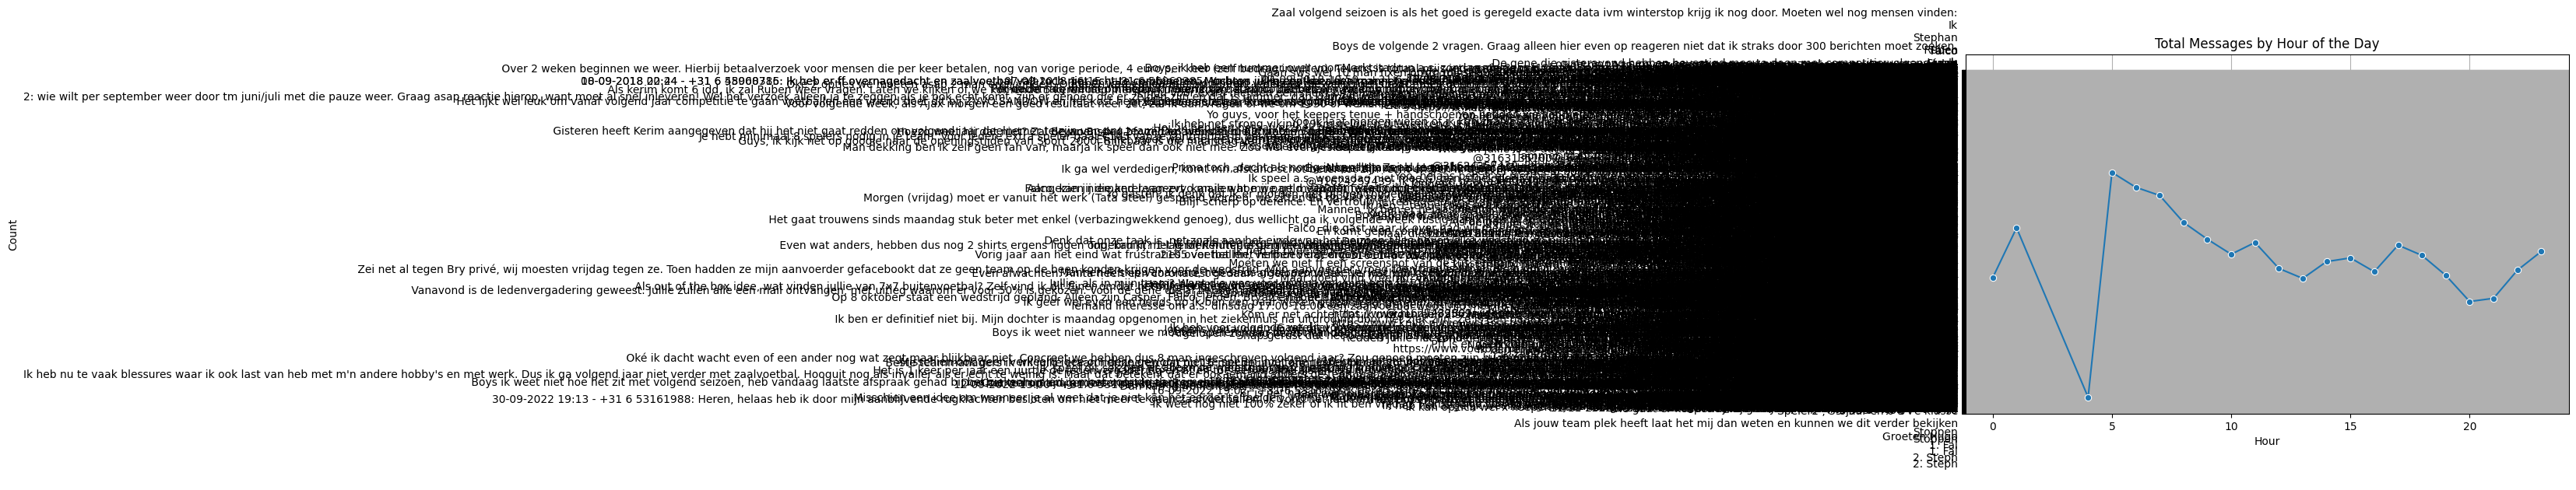

In [13]:

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='hour', y='message', marker='o')

plt.title('Total Messages by Hour of the Day')
plt.xlabel('Hour')
plt.ylabel('Count')

plt.grid(True)
plt.show()

In [15]:

hour_grouped_msg =  (df.set_index('hour')['message']
                          .groupby(level=0)
                          .value_counts()
                          .groupby(level=0)
                          .sum()
                          .reset_index(name='count'))
fig = px.line(hour_grouped_msg, x='hour', y='count',
                 labels={'hour':'24 Hour Period'}, 
                 height=400)
fig.update_traces(marker_color='#EDCC8B', marker_line_color='#D4A29C',
                  marker_line_width=0.5, opacity=0.6)
fig.update_layout(title_text='Total Messages by Hour of the Day')
fig.show()

In [93]:
import pandas as pd
import plotly.express as px

# Assuming 'df' is your DataFrame with 'timestamp' and 'message' columns
df['weekday'] = df['timestamp'].dt.day_name()
df['year'] = df['timestamp'].dt.year

weekday_grouped_msg = (df.groupby(['year', 'weekday'])['message']
                          .value_counts()
                          .groupby(['year', 'weekday'])
                          .sum()
                          .reset_index(name='count'))

# Sort the 'weekday' column in the desired order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_grouped_msg['weekday'] = pd.Categorical(weekday_grouped_msg['weekday'], categories=weekday_order, ordered=True)

# Sort the DataFrame by 'year' and 'weekday'
weekday_grouped_msg = weekday_grouped_msg.sort_values(by=['year', 'weekday'])
category_orders = {'weekday': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']}

fig = px.line_polar(weekday_grouped_msg, r='count', theta='weekday', color='year',
                    line_close=True, template='plotly_dark', category_orders=category_orders)

max_count_value = weekday_grouped_msg['count'].max()
fig.update_traces(fill='toself')
fig.update_layout(
    polar=dict(radialaxis=dict(visible=True, title='Aantal berichten')),
    showlegend=True,
    title='Aantal berichten per dag en jaren van een zaalvoetbal team'
)

annotation_text = "Vanaf 2022 is de speeldag van voetbal verplaatst van woensdag naar vrijdag. <br> Dit is terug te zien in het aantal berichten per dag"
fig.add_annotation(
    go.layout.Annotation(
        text=annotation_text,
        xref="paper", yref="paper",
        x=0.02, y=.950,
        showarrow=False,
        font=dict(size=12, color="white"),
    )
)

img_directory = 'img'
os.makedirs(img_directory, exist_ok=True)

# Save the plot as an HTML file
html_file_path = os.path.join(r'C:\Users\a427617\Documents\Master Data science\Blok 3 - Data mining\Data-Mining---2024', img_directory, 'msg_count_weekday_year.html')

fig.write_html(html_file_path)

print(f"Plot saved as HTML: {html_file_path}")

fig.show()


Plot saved as HTML: C:\Users\a427617\Documents\Master Data science\Blok 3 - Data mining\Data-Mining---2024\img\msg_count_weekday_year.html


In [58]:
import plotly.subplots as sp
import plotly.graph_objects as go
import os

# Assuming 'df' is your DataFrame with 'timestamp' and 'message' columns
df['weekday'] = df['timestamp'].dt.day_name()
df['year'] = df['timestamp'].dt.year

weekday_grouped_msg = (df.groupby(['year', 'weekday'])['message']
                          .value_counts()
                          .groupby(['year', 'weekday'])
                          .sum()
                          .reset_index(name='count'))

# Sort the 'weekday' column in the desired order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_grouped_msg['weekday'] = pd.Categorical(weekday_grouped_msg['weekday'], categories=weekday_order, ordered=True)

# Sort the DataFrame by 'year' and 'weekday'
weekday_grouped_msg = weekday_grouped_msg.sort_values(by=['year', 'weekday'])

# Create a subplot with Plotly
fig = sp.make_subplots(rows=1, cols=1, subplot_titles=['Message Count by Weekday and Year'])

for year in weekday_grouped_msg['year'].unique():
    data_year = weekday_grouped_msg[weekday_grouped_msg['year'] == year]
    trace = go.Scatterpolar(r=data_year['count'], theta=data_year['weekday'], fill='toself', name=str(year))
    fig.add_trace(trace)

fig.update_layout(
    polar=dict(radialaxis=dict(visible=True)),
    showlegend=True
)

# Add HTML-formatted text annotation with line breaks
annotation_text = "Wat opvalt is de verschuiving van het aantal berichten per dag door de jaren heen. <br>In de laatste 2 jaar is de speeldag van voetbal verplaatst van woensdag naar vrijdag."
fig.add_annotation(
    go.layout.Annotation(
        text=annotation_text,
        xref="paper", yref="paper",
        x=0.5, y=-0.15,
        showarrow=False,
        font=dict(size=12, color="white"),
    )
)

# Create the 'img' directory if it doesn't exist
img_directory = 'img'
os.makedirs(img_directory, exist_ok=True)

# Save the plot as an HTML file
html_file_path = os.path.join(r'C:\Users\a427617\Documents\Master Data science\Blok 3 - Data mining\Data-Mining---2024', img_directory, 'msg_count_weekday_year.html')

fig.write_html(html_file_path)

print(f"Plot saved as HTML: {html_file_path}")


Plot saved as HTML: C:\Users\a427617\Documents\Master Data science\Blok 3 - Data mining\Data-Mining---2024\img\msg_count_weekday_year.html


In [62]:
import plotly.subplots as sp
import plotly.graph_objects as go
import os

# Assuming 'df' is your DataFrame with 'timestamp' and 'message' columns
df['weekday'] = df['timestamp'].dt.day_name()
df['year'] = df['timestamp'].dt.year

weekday_grouped_msg = (df.groupby(['year', 'weekday'])['message']
                          .value_counts()
                          .groupby(['year', 'weekday'])
                          .sum()
                          .reset_index(name='count'))

# Sort the 'weekday' column in the desired order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_grouped_msg['weekday'] = pd.Categorical(weekday_grouped_msg['weekday'], categories=weekday_order, ordered=True)

# Sort the DataFrame by 'year' and 'weekday'
weekday_grouped_msg = weekday_grouped_msg.sort_values(by=['year', 'weekday'])

# Create a subplot with Plotly
fig = sp.make_subplots(rows=1, cols=1, subplot_titles=['Message Count by Weekday and Year'])

for year in weekday_grouped_msg['year'].unique():
    data_year = weekday_grouped_msg[weekday_grouped_msg['year'] == year]
    trace = go.Scatterpolar(r=data_year['count'], theta=data_year['weekday'], fill='toself', name=str(year))
    fig.add_trace(trace)

fig.update_layout(
    polar=dict(radialaxis=dict(visible=True)),
    showlegend=True
)

# Add HTML-formatted text annotation with line breaks
annotation_text = "Wat opvalt is de verschuiving van het aantal berichten per dag door de jaren heen. <br>In de laatste 2 jaar is de speeldag van voetbal verplaatst van woensdag naar vrijdag."
fig.add_annotation(
    go.layout.Annotation(
        text=annotation_text,
        xref="paper", yref="paper",
        x=0.5, y=-0.15,
        showarrow=False,
        font=dict(size=12, color="white"),
    )
)

# Create the 'img' directory if it doesn't exist
img_directory = 'img'
os.makedirs(img_directory, exist_ok=True)

# Save the plot as an HTML file
html_file_path = os.path.join(r'C:\Users\a427617\Documents\Master Data science\Blok 3 - Data mining\Data-Mining---2024', img_directory, 'msg_count_weekday_year.html')
fig.write_html(html_file_path)

print(f"Plot saved as HTML: {html_file_path}")


Plot saved as HTML: C:\Users\a427617\Documents\Master Data science\Blok 3 - Data mining\Data-Mining---2024\img\msg_count_weekday_year.html


In [63]:
import pandas as pd
import plotly.subplots as sp
import plotly.graph_objects as go
import os

# Assuming 'df' is your DataFrame with 'timestamp' and 'message' columns
df['weekday'] = df['timestamp'].dt.day_name()
df['year'] = df['timestamp'].dt.year

weekday_grouped_msg = (df.groupby(['year', 'weekday'])['message']
                          .value_counts()
                          .groupby(['year', 'weekday'])
                          .sum()
                          .reset_index(name='count'))

# Define the 'weekday_order' list starting with Monday at the north position
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Convert the 'weekday' column to a categorical type with specified order
weekday_grouped_msg['weekday'] = pd.Categorical(weekday_grouped_msg['weekday'], categories=weekday_order, ordered=True)

# Sort the DataFrame by 'year' and 'weekday'
weekday_grouped_msg = weekday_grouped_msg.sort_values(by=['year', 'weekday'])

# Create a subplot with Plotly
fig = sp.make_subplots(rows=1, cols=1, subplot_titles=['Message Count by Weekday and Year'])

for year in weekday_grouped_msg['year'].unique():
    data_year = weekday_grouped_msg[weekday_grouped_msg['year'] == year]
    
    # Reorder the data to start with Monday at the north position
    data_year['weekday'] = pd.Categorical(data_year['weekday'], categories=weekday_order, ordered=True)
    data_year = data_year.sort_values(by='weekday')
    
    trace = go.Scatterpolar(r=data_year['count'], theta=data_year['weekday'], fill='toself', name=str(year))
    fig.add_trace(trace)

fig.update_layout(
    polar=dict(radialaxis=dict(visible=True)),
    showlegend=True
)

# Add HTML-formatted text annotation with line breaks
annotation_text = "Wat opvalt is de verschuiving van het aantal berichten per dag door de jaren heen. <br>In de laatste 2 jaar is de speeldag van voetbal verplaatst van woensdag naar vrijdag."
fig.add_annotation(
    go.layout.Annotation(
        text=annotation_text,
        xref="paper", yref="paper",
        x=0.5, y=-0.15,
        showarrow=False,
        font=dict(size=12, color="white"),
    )
)

# Create the 'img' directory if it doesn't exist
img_directory = 'img'
os.makedirs(img_directory, exist_ok=True)

# Save the plot as an HTML file
html_file_path = os.path.join(r'C:\Users\a427617\Documents\Master Data science\Blok 3 - Data mining\Data-Mining---2024', img_directory, 'msg_count_weekday_year.html')
fig.write_html(html_file_path)

print(f"Plot saved as HTML: {html_file_path}")


Plot saved as HTML: C:\Users\a427617\Documents\Master Data science\Blok 3 - Data mining\Data-Mining---2024\img\msg_count_weekday_year.html


C:\Users\a427617\AppData\Local\Temp\ipykernel_15312\3783145589.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [8]:
total_messages = df.shape[0]
media_messages = df[df['message'] == '<Multimedia omitido>'].shape[0]
average_message_words = df['Word_Count'].mean()
average_message_letters = df['Letter_Count'].mean()
average_message_day = df.groupby('date')['message'].count().mean()
print('Total Messages ',total_messages)
print('Media Message', media_messages)
print('Average Words by Messages', round(average_message_words, 2))
print('Average Letters by Messages', round(average_message_letters, 2))
print('Average Message Per Day', round(average_message_day, 2))

Total Messages  87428
Media Message 0
Average Words by Messages 8.45
Average Letters by Messages 52.38
Average Message Per Day 36.58


author
Bryan Zaagsma             1755
Falco                      896
Tom Danko                  847
Justin Velthuijsen         773
Bryan Bibo                 551
Romano Mundo               473
Jeroen Huter               296
Casper Guit                269
Stephan van den Hoogen     261
Kay Jacobs                 249
Ruben Zaalvoetbal          212
Jeroen Zaalvoetbal         176
Belly Zaalvoetbal          124
+31 6 25359296              87
Tom Schokker                76
Kerim Ozel                  70
Unknown                     43
Kevin Zaagsma               21
+31 6 53161988              12
+31 6 15270734              12
Richard van den Hoogen       9
+31 6 48575116               7
+31 6 10819296               7
Mark Zaalvoetbal             6
+31 6 37140834               5
+31 6 48008716               4
+31 6 48131664               3
+31 6 55960385               2
Name: count, dtype: int64

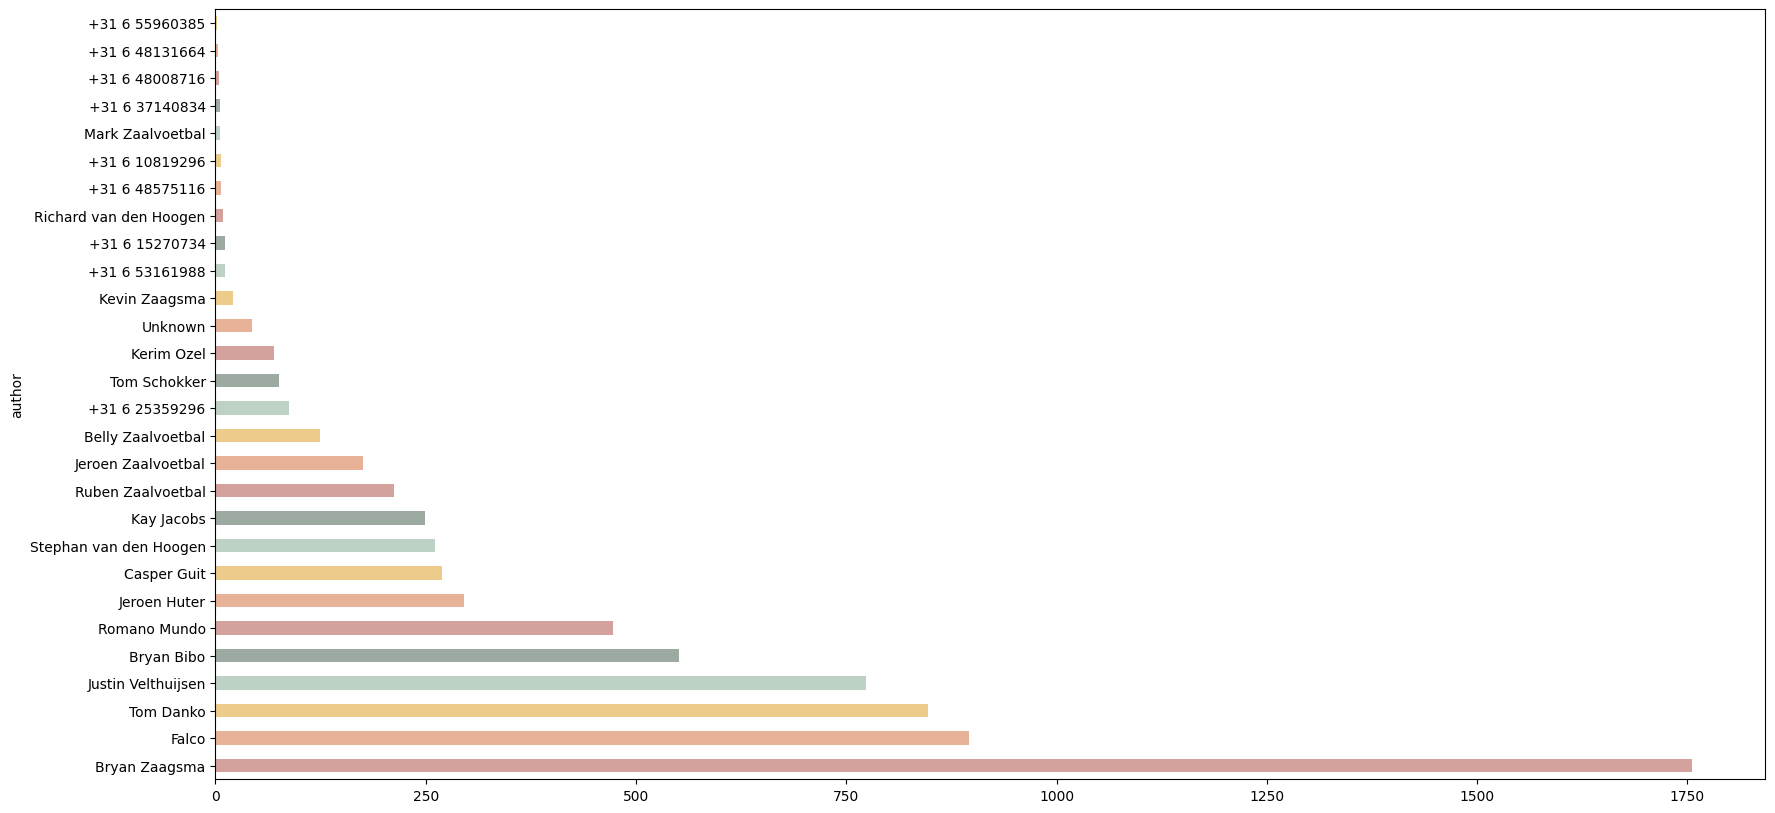

In [11]:
qty_message_author = df['author'].value_counts()
qty_message_author.plot(kind='barh',figsize=(20,10), color=['#D4A29C', '#E8B298', '#EDCC8B', '#BDD1C5', '#9DAAA2'])
qty_message_author

Let's count the amount of messages, per author.

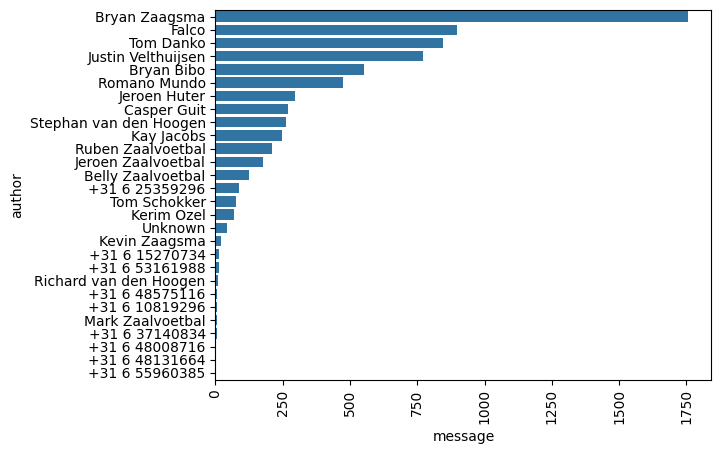

In [5]:
p1 = df[['author', 'message']].\
    groupby("author").\
    count().\
    sort_values("message", ascending=False)
sns.barplot(y=p1.index, x="message", data=p1)
plt.xticks(rotation=90);

Maybe tweak the colors a bit

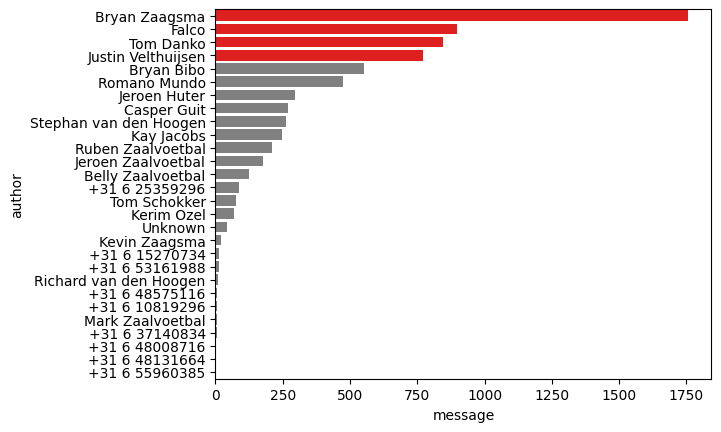

In [6]:
colors = [0 if x < 700 else 1 for x in p1.message]
custom_palette = {0: "grey", 1: "red"}
sns.barplot(y=p1.index, x="message", hue=colors, data=p1, palette=custom_palette, legend=False);

Let's calculate the average message length.

Text(0.5, 0, 'Average message length')

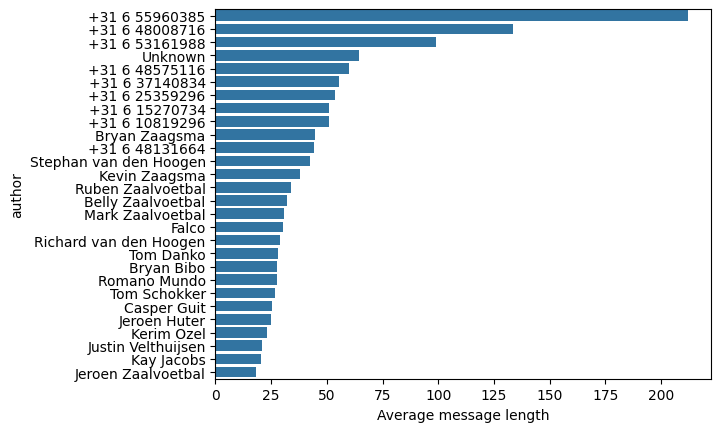

In [7]:
df['message_length'] = df['message'].str.len()
p1 = df[['author', 'message_length']].\
    groupby("author").\
    mean().\
    sort_values("message_length", ascending=False)
sns.barplot(y=p1.index, x="message_length", data=p1)
plt.xlabel("Average message length")

Create a simple regex to look for links in the messages and add that as a feature:

<Axes: xlabel='has_link', ylabel='author'>

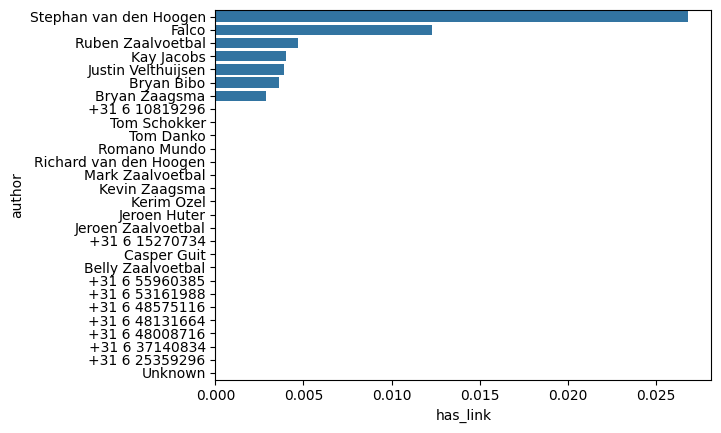

In [8]:
has_link = r"http"
df['has_link'] = df['message'].str.contains(has_link)
p1 = df[['author', 'has_link']].\
    groupby("author").\
    mean().\
    sort_values("has_link", ascending=False)
sns.barplot(y=p1.index, x="has_link", data=p1)

Aggregate the emojis per user (can you change between sum and mean?)

<Axes: xlabel='sum', ylabel='author'>

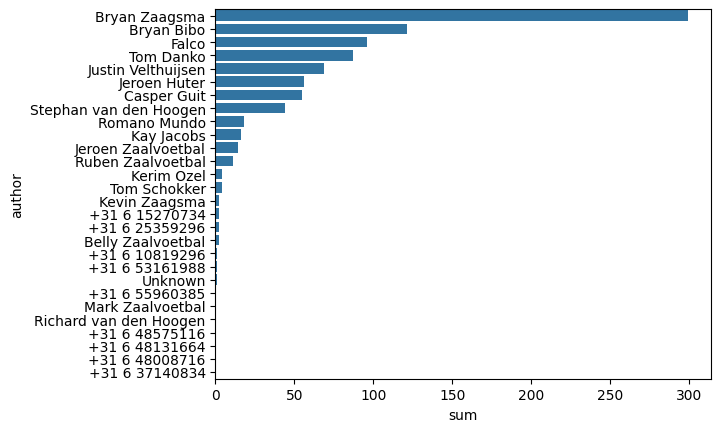

In [11]:
p2 = df[['author', 'has_emoji']].\
    groupby('author').\
    agg(['sum', 'mean']).\
    sort_values(('has_emoji', 'sum'), ascending=False)
p2.columns = p2.columns.droplevel(0)
sns.barplot(y=p2.index, x="sum", data=p2)

Let's add a cateory, based on the time when authors send a message:

In [15]:
import pandas as pd
# Define the time ranges
time_ranges = ['00:00', '08:00', '17:30', '22:00', '23:59']
# Define the category labels
categories = ['early morning', 'worktimes', 'evening', 'late']
# Categorize the timestamp column
df['timestamp_category'] = pd.cut(df['timestamp'].dt.time.astype(str), bins=time_ranges, labels=categories, right=False)
# Display the updated dataframe
df

ValueError: could not convert string to float: '00:00'

Now we can group and count the categories:

In [16]:
# Group the dataframe by 'author' and 'timestamp_category', and count the occurrences
p3 = df.groupby(['author', 'timestamp_category']).size().unstack()

# Calculate the fraction of each category for every author
p3_frac = p3.div(p3.sum(axis=1), axis=0)
p3_frac

KeyError: 'timestamp_category'

Let's use plotly the create a stacked bar chart:

In [ ]:
import plotly.express as px
p4 = p3_frac.reset_index().melt(id_vars='author')
fig = px.bar(p4, y="author", x="value", color="timestamp_category", barmode="stack")
fig.show()

Let's extract the minimum and maximum time of the messages for every author, and convert that to a decimal fraction:

In [17]:
df['hour'] = df['timestamp'].dt.time
summary_df = df.groupby('author')['hour'].agg(['min', 'max']).reset_index()

def convert_to_decimal_hours(timestamp):
    dec_hour = timestamp.hour + timestamp.minute / 60 + timestamp.second / 3600
    return dec_hour

summary_df['min_x_values'] = summary_df['min'].apply(convert_to_decimal_hours)
summary_df['max_x_values'] = summary_df['max'].apply(convert_to_decimal_hours)

# Drop the original 'min' and 'max' columns as they are no longer needed
summary_df = summary_df.drop(['min', 'max'], axis=1)
summary_df.head()

,author,min_x_values,max_x_values
0,+31 6 10819296,9.216667,19.250000
1,+31 6 15270734,10.450000,18.133333
2,+31 6 25359296,8.716667,22.350000
3,+31 6 37140834,9.900000,19.883333
4,+31 6 48008716,10.833333,23.216667


With this, we can create a nice barbell chart. Try to add colors for your own chart!

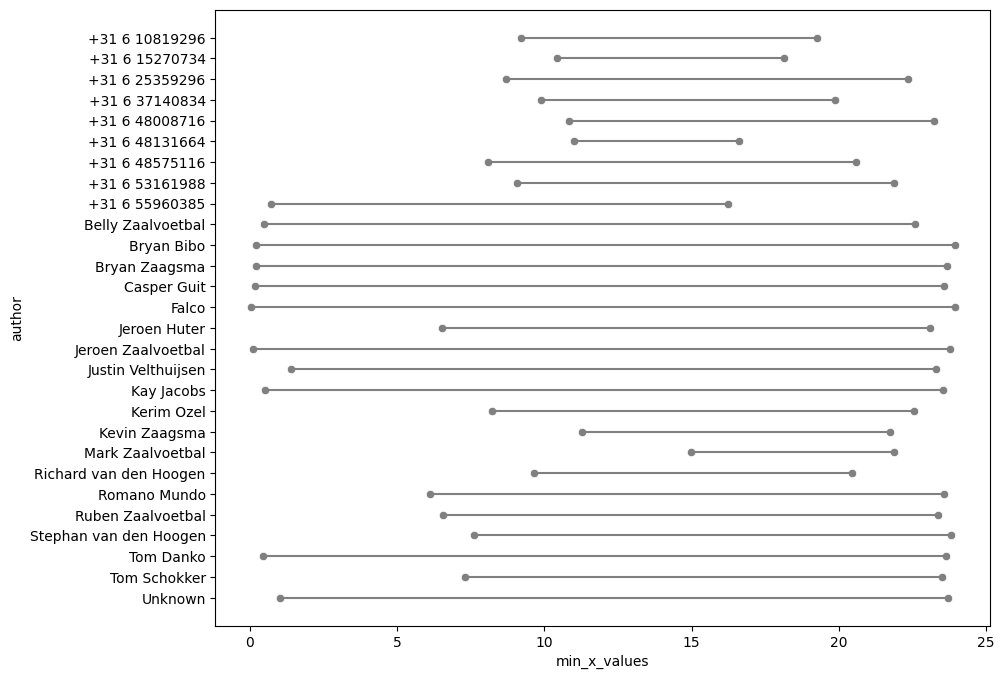

In [18]:
# Create a larger plot
plt.figure(figsize=(10, 8))

# Create scatter plots
sns.scatterplot(data=summary_df, x='min_x_values', y='author', color='grey')
sns.scatterplot(data=summary_df, x='max_x_values', y='author', color='grey')

# Add lines
for index, row in summary_df.iterrows():
    plt.plot([row['min_x_values'], row['max_x_values']], [row['author'], row['author']], color='grey')


# Adjust the font size of the y-axis labels if needed
plt.yticks(fontsize=10)

# Show the plot
plt.show()

Another approach for comparing is to create a heatmap:

<Axes: xlabel='day_of_week', ylabel='author'>

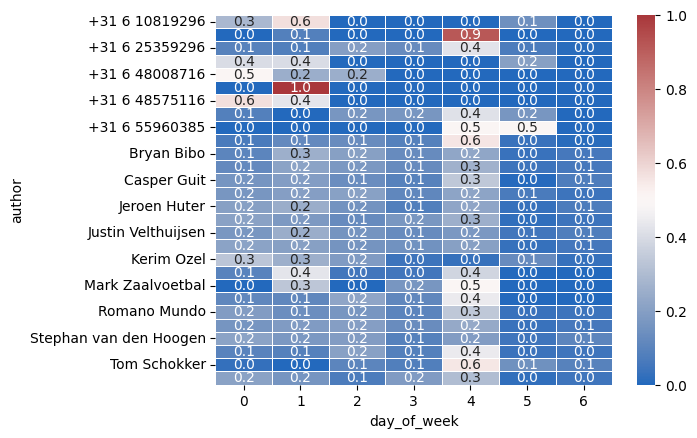

In [19]:
df['day_of_week'] = df['timestamp'].dt.dayofweek
author_day_counts = df.groupby(['author', 'day_of_week']).size().unstack(fill_value=0)
author_day_percentages = author_day_counts.div(author_day_counts.sum(axis=1), axis=0)
sns.heatmap(author_day_percentages, annot=True, fmt=".1f", linewidths=.5, cmap="vlag")

Let's save all the new features we added:

In [20]:
df.to_parquet(datafile, index=False)